In [ ]:
!pip install tensorflow keras gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing in

### Imports

In [ ]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


### Load image dataset & generate image data



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
#defining paths of test and training images
train_dataset_path = '/content/drive/MyDrive/train'
test_dataset_path = '/content/drive/MyDrive/test'
valid_dataset_path = '/content/drive/MyDrive/valid'

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.15,
    shear_range=0.15,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    classes=['GoldenEagle', 'NotGoldenEagle'],
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'

)

validation_generator = validation_datagen.flow_from_directory(
    valid_dataset_path,
    classes=['GoldenEagle', 'NotGoldenEagle'],
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    classes=['GoldenEagle', 'NotGoldenEagle'],
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)


Found 1226 images belonging to 2 classes.
Found 110 images belonging to 2 classes.
Found 303 images belonging to 2 classes.


### Building & training the CNN

In [57]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(128, (3, 3), input_shape=(128, 128, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(256, (3, 3), kernel_regularizer= l2(0.0001), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Fourth convolutional layer
model.add(Conv2D(256, (3, 3), kernel_regularizer= l2(0.0001), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(256, activity_regularizer= l2(0.0001), activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1,kernel_regularizer= l2(0.001), activation='sigmoid'))

# Compiling the CNN
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Defining checkpointing, to restore the best epoch
model_checkpoint = ModelCheckpoint(
    filepath='/content/finished_modelsNew/best_model1.keras',  # Path to save the model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


#Training the CNN
history = model.fit(
    train_generator,
    steps_per_epoch= train_generator.samples // 32,
    epochs=45,
    validation_data=validation_generator,
    validation_steps= validation_generator.samples //32,
    callbacks=[model_checkpoint]
)
model.summary()

test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6363 - loss: 0.7283
Epoch 1: val_accuracy improved from -inf to 0.59375, saving model to /content/finished_modelsNew/best_model1.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 341ms/step - accuracy: 0.6375 - loss: 0.7272 - val_accuracy: 0.5938 - val_loss: 0.7839
Epoch 2/45
 1/38 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.8438 - loss: 0.5185

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.59375 to 0.64286, saving model to /content/finished_modelsNew/best_model1.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8438 - loss: 0.5185 - val_accuracy: 0.6429 - val_loss: 0.7923
Epoch 3/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.7041 - loss: 0.6453
Epoch 3: val_accuracy did not improve from 0.64286
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 312ms/step - accuracy: 0.7040 - loss: 0.6455 - val_accuracy: 0.5729 - val_loss: 0.7033
Epoch 4/45
 1/38 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7500 - loss: 0.6535
Epoch 4: val_accuracy improved from 0.64286 to 0.78571, saving model to /content/finished_modelsNew/best_model1.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7500 - loss: 0.6535 - val_accuracy: 0.7857 - val_loss: 0.6500
Epoch 5/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7281 - loss: 0.6431
Epoch 5: val_accuracy did not improve from 0.78571
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 306ms/step - accuracy: 

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)                   │ (None, 126, 126, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 63, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 61, 61, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 28, 28, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,516,165 (43.93 MB)

 Trainable params: 3,838,721 (14.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,677,444 (29.29 MB)

10/10 - 2s - 187ms/step - accuracy: 0.8713 - loss: 0.3382
Test Loss: 0.33817675709724426
Test Accuracy: 0.8712871074676514


###Plotting the training and validation loss / accuracy

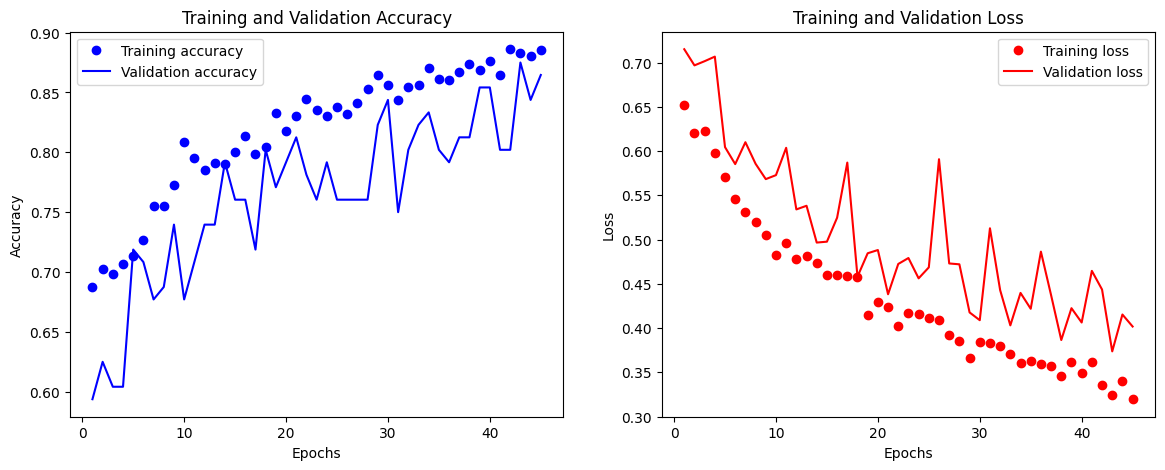

In [ ]:
# Extracting accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Number of epochs
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Calculating metrics

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step
True Positives: 247
True Negatives: 4
False Positives: 22
False Negatives: 30
                precision    recall  f1-score   support

NotGoldenEagle       0.12      0.15      0.13        26
   GoldenEagle       0.92      0.89      0.90       277

      accuracy                           0.83       303
     macro avg       0.52      0.52      0.52       303
  weighted avg       0.85      0.83      0.84       303



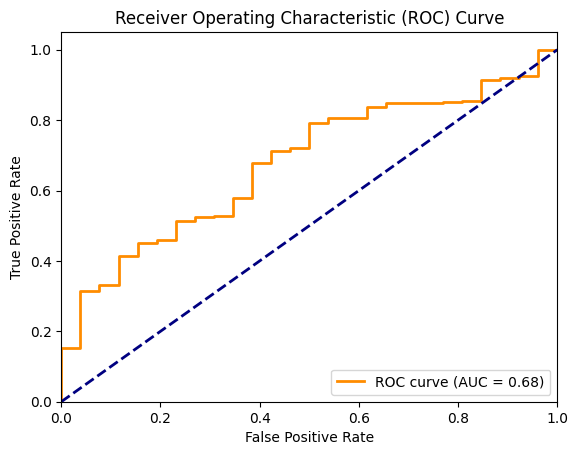

In [63]:
from sklearn.metrics import roc_curve, auc

best_model = load_model('/content/finished_models/best_model.keras')

# Generate predictions on the test set
test_generator.reset()
predictions = best_model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Flatten to make it 1D array

# Get the true labels from the test generator
true_classes = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
tn, fp, fn, tp = cm.ravel()

print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

# Calculate AUC
# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Classification report for additional metrics
report = classification_report(true_classes, predicted_classes, target_names=['NotGoldenEagle', 'GoldenEagle'])

print(report)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### Loading and predicting from saved model

In [64]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#path to load the best model
best_model = load_model('/content/finished_models/best_model.keras')

#function that returns the prediction
def predict_image(img):
    # Preprocessing for the image
    img = img.resize((128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Making the prediction
    preprocessed_img = img_array
    prediction = best_model.predict(preprocessed_img)[0][0]
    class_name = "Not golden eagle" if prediction > 0.5 else "Golden eagle"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return f"{class_name} (Confidence: {confidence:.2f})"



# Create Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Text(label="Prediction"),
    title="Golden Eagle ",
    description="Upload an image to get a prediction from the trained CNN model."
)


# Launch the interface
iface.launch(debug=True, share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://a6cf267f0a727f7108.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a6cf267f0a727f7108.gradio.live
